In [28]:
from bb_binary import FrameContainer, Repository, load_frame_container
from collections import namedtuple
from collections import Counter
from pandas import DataFrame, Series
import preprocessing as prep

import multiprocessing
import sqlite3
import numpy as np
import pandas as pd
import sys
import datetime
import pytz

import matplotlib.pyplot as plt

In [56]:
def createAllTables(c):

    c.execute('''DROP TABLE IF EXISTS FRAME_CONTAINER''')
    c.execute('''DROP TABLE IF EXISTS FRAME''')
    c.execute('''DROP TABLE IF EXISTS DETECTIONS''')

    c.execute('''CREATE TABLE FRAME_CONTAINER (\
    FC_ID  INT PRIMARY KEY,\
    ID  TEXT,\
    CAM_ID  INT,\
    FROM_TS  INT,\
    TO_TS  INT\
    );''')

    c.execute('''CREATE TABLE FRAME (\
    FRAME_ID  INT PRIMARY KEY,\
    FC_ID  INT,\
    TIMESTAMP  INT,\
    FOREIGN KEY(FC_ID) REFERENCES FRAME_CONTAINER(FC_ID)\
    );''')

    c.execute('''CREATE TABLE DETECTIONS (\
    FRAME_ID  INT,\
    XPOS  INT,\
    YPOS  INT,\
    ZROTATION FLOAT,\
    ID INT,\
    FOREIGN KEY(FRAME_ID) REFERENCES FRAME(FRAME_ID)\
    );''')

In [72]:
Detection = namedtuple(
    'Detection',
    ['frame_id', 'xpos', 'ypos', 'zRotation', 'decodedId']
)

In [98]:
db_path = "/storage/mi/aschle/data.db"
conn = sqlite3.connect(db_path)
c = conn.cursor()
createAllTables(c)

In [111]:
repo = Repository("/storage/mi/aschle/days/")
confidence = 0.99
start = "2015-08-21T00:00:00Z"
start_dt = datetime.datetime.strptime(start, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=pytz.UTC)
start_ts = start_dt.timestamp()

end_dt = start_dt + datetime.timedelta(hours=24)
end_ts = end_dt.timestamp()

In [116]:
files = list(repo.iter_fnames(begin=start_ts, end=end_ts))

In [118]:
len(files)/4

254.0

In [99]:
my_fc_id = 0
my_frame_id = 0

# alle dateien bzw. FrameConatiner interieren
for file in files[:4]:
    fc = load_frame_container(file)

    # pro Framecontainer ein Eintrag in die FrameContainer Table machen
    c.execute("insert into frame_container (fc_id, id, cam_id, from_ts, to_ts) values (?, ?, ?, ?, ?)",
              (my_fc_id, str(fc.id), fc.camId, fc.fromTimestamp, fc.toTimestamp))
    
    # alle Frames iterieren
    tpls = []

    for f in fc.frames:
        # pro frame einen Eintrag in Frame Tabelle machen
        c.execute("insert into frame (frame_id, fc_id, timestamp) values (?, ?, ?)",
                  (my_frame_id, my_fc_id, f.timestamp))

        # alle Detections iterieren
        for d in f.detectionsUnion.detectionsDP:
            d = Detection(my_frame_id, d.xpos, d.ypos, d.zRotation, list(d.decodedId))
            tpls.append(d)
        
        # hochzaehlen
        my_frame_id += 1

    df = pd.DataFrame(tpls) 
    df = prep.calcIds(df, confidence)
    df.drop('confidence', axis=1, inplace=True)
    
    # Detections zu db hinzufuegen
    df.to_sql('DETECTIONS', conn, if_exists='append', index=False)
    
    # hochzaehlen!
    my_fc_id += 1

# Datenbank wieder auslesen

In [2]:
import networkx as nx

In [3]:
G = nx.read_graphml("networks-days/2015-08-21T00:00:00Z_1d_allCams_0.99conf_160dist_6ilen.graphml")

In [4]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1202
Number of edges: 152449
Average degree: 253.6589


In [5]:
%matplotlib inline

In [5]:
closenessc = nx.closeness.closeness_centrality(G)

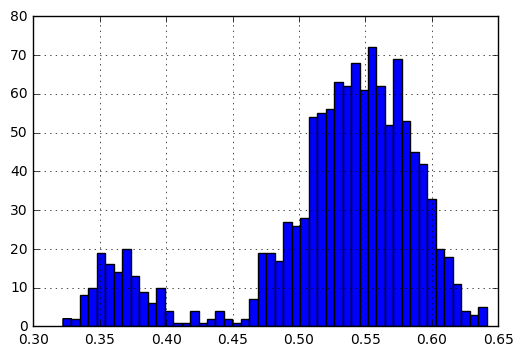

In [8]:
Series(closenessc).hist(bins=50)

In [9]:
line = 0.45
s = Series(closenessc)
smaller = s[s < line]
bigger = s[s > line]
IDsmaller = [int(i) for i in smaller.index]
IDbigger = [int(i) for i in bigger.index]

In [6]:
db_path = "/storage/mi/aschle/data.db"
conn = sqlite3.connect(db_path)
c = conn.cursor()

In [16]:
c.execute("CREATE INDEX idx ON DETECTIONS(ID);")

In [50]:
c.execute("CREATE INDEX det_frameid ON DETECTIONS(FRAME_ID);")
c.execute("CREATE INDEX frame_frameid ON FRAME(FRAME_ID);")
c.execute("CREATE INDEX frame_fcid ON FRAME(FC_ID);")
c.execute("CREATE INDEX fc_fcid ON FRAME_CONTAINER(FC_ID);")

#     ON d.FRAME_ID=f.FRAME_ID
#     INNER JOIN FRAME_CONTAINER fc
#     ON f.FC_ID=fc.FC_ID

In [11]:
len(IDsmaller)

148

In [12]:
len(IDbigger)

1054

In [56]:
ids_str = ', '.join([str(x) for x in IDsmaller])
sql = '''
    SELECT d.XPOS, d.YPOS, d.ID, fc.CAM_ID
    FROM DETECTIONS d
    INNER JOIN FRAME f
    ON d.FRAME_ID=f.FRAME_ID
    INNER JOIN FRAME_CONTAINER fc
    ON f.FC_ID=fc.FC_ID
    WHERE d.ID IN ({});
'''.format(ids_str)
x = pd.read_sql(sql, conn)

In [74]:
x.shape

(61389, 4)

In [27]:
import matplotlib.pyplot as plt

In [95]:
data3.shape

(12127, 4)

In [110]:
x_b[x_b.CAM_ID == 0].groupby('ID').std().describe()

,XPOS,YPOS,CAM_ID
count,1054.000000,1054.000000,1054.0
mean,600.228438,644.610269,0.0
std,154.485659,184.505246,0.0
min,183.041793,243.286461,0.0
25%,490.580270,508.587021,0.0
50%,619.131399,625.446813,0.0
75%,710.708651,764.789595,0.0
max,1010.881474,1338.477407,0.0


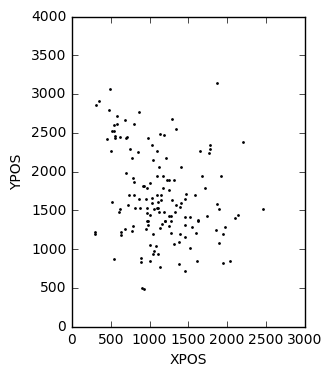

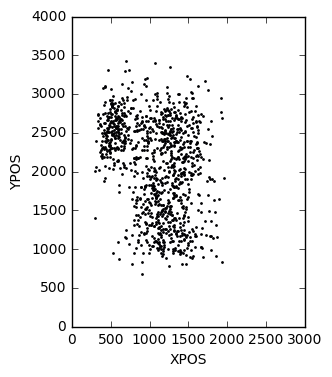

In [103]:
data0 = x[x.CAM_ID == 0]
data0 = data0.groupby('ID').median()
data0.plot.scatter(x='XPOS', y="YPOS",s=1, xlim=(0,3000),ylim=(0,4000))
plt.axes().set_aspect('equal')
plt.show()

data0b = x_b[x_b.CAM_ID == 0].groupby('ID').mean()
data0b.plot.scatter(x='XPOS', y="YPOS",s=1, xlim=(0,3000),ylim=(0,4000))
plt.axes().set_aspect('equal')

In [159]:
def plotClosenessXY(txt, df, camIDleft, camIDright, s=2000):
    data_l = df[df.CAM_ID == camIDleft].sample(s)
    data_r = df[df.CAM_ID == camIDright].sample(s)
    data_r.XPOS = data_r.XPOS + 3000
    data = pd.concat([data_l,data_r])
    data.plot.scatter(x='XPOS', y="YPOS",s=1, xlim=(0,6000),ylim=(0,4000), alpha=0.1)
    plt.axes().set_aspect('equal')
    plt.axes().set_title("{} \nCam {} & Cam {}".format(txt, str(camIDleft), str(camIDright)))

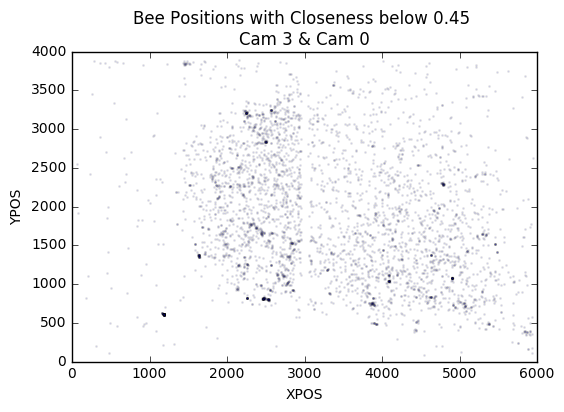

In [161]:
plotClosenessXY("Bee Positions with Closeness below 0.45", x,3,0)

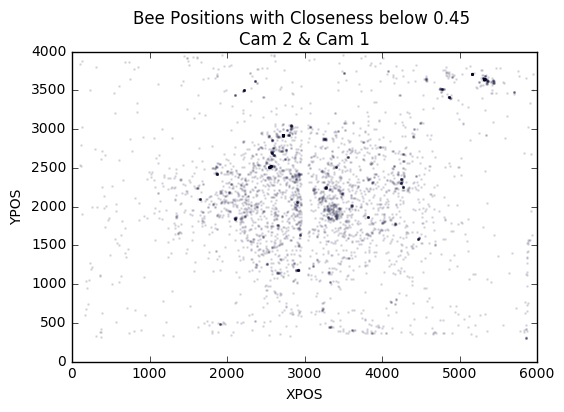

In [162]:
plotClosenessXY("Bee Positions with Closeness below 0.45",x,2,1)

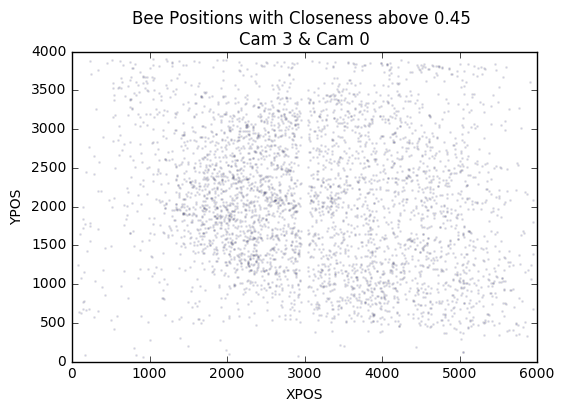

In [163]:
plotClosenessXY("Bee Positions with Closeness above 0.45", x_b,3,0)

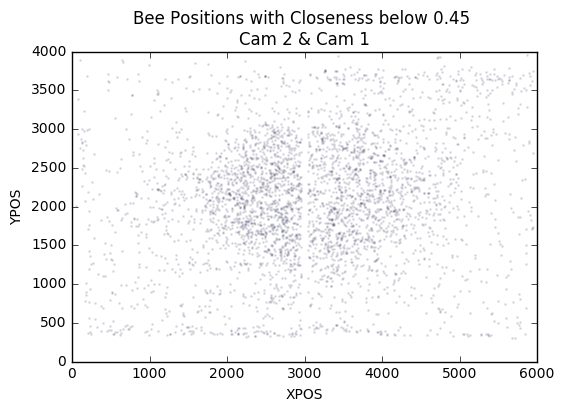

In [164]:
plotClosenessXY("Bee Positions with Closeness below 0.45", x_b,2,1)

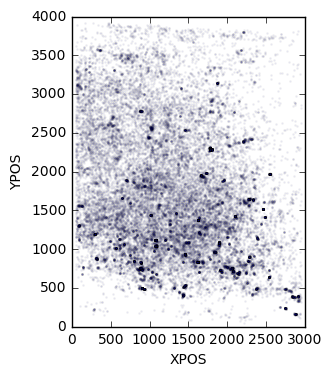

In [66]:
data0 = x[x.CAM_ID == 0]
data0.plot.scatter(x='XPOS', y="YPOS",s=1, xlim=(0,3000),ylim=(0,4000), alpha=0.05)
plt.axes().set_aspect('equal')

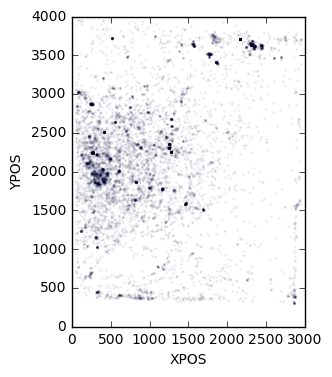

In [67]:
data1 = x[x.CAM_ID == 1]
data1.XPOS = data1.XPOS + 3000
data1.plot.scatter(x='XPOS', y="YPOS",s=1, xlim=(0,3000),ylim=(0,4000), alpha=0.05)
plt.axes().set_aspect('equal')

In [120]:
data1.XPOS = data1.XPOS + 3000

/home/mi/aschle/miniconda3/lib/python3.5/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


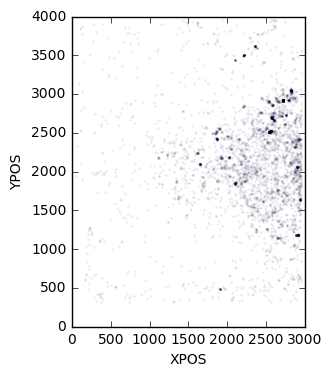

In [68]:
data2 = x[x.CAM_ID == 2]
data2.plot.scatter(x='XPOS', y="YPOS",s=1, xlim=(0,3000),ylim=(0,4000), alpha=0.05)
plt.axes().set_aspect('equal')

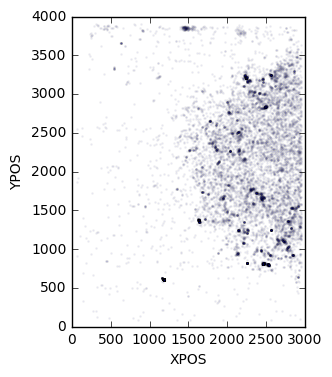

In [69]:
data3 = x[x.CAM_ID == 3]
data3.plot.scatter(x='XPOS', y="YPOS",s=1, xlim=(0,3000),ylim=(0,4000), alpha=0.05)
plt.axes().set_aspect('equal')

In [70]:
ids_str_bigger = ', '.join([str(x) for x in IDbigger])
sql = '''
    SELECT d.XPOS, d.YPOS, d.ID, fc.CAM_ID
    FROM DETECTIONS d
    INNER JOIN FRAME f
    ON d.FRAME_ID=f.FRAME_ID
    INNER JOIN FRAME_CONTAINER fc
    ON f.FC_ID=fc.FC_ID
    WHERE d.ID IN ({});
'''.format(ids_str_bigger)
x_b = pd.read_sql(sql, conn)

In [71]:
x_b.shape 59331842

(59012227, 4)

In [73]:
59331842-x_b.shape[0]

319615

In [72]:
x_b.sample(10000).plot.scatter(x='XPOS')

,XPOS,YPOS,ID,CAM_ID
0,2575,2899,12,3
1,2575,2911,12,3
2,2562,2788,12,3
3,2561,2787,12,3
4,2549,2788,12,3


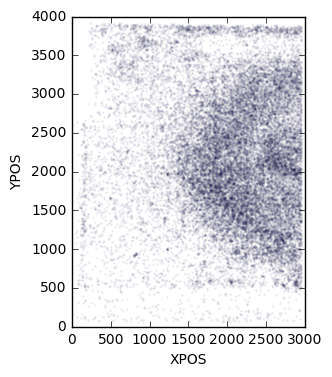

In [83]:
data3b = x_b[x_b.CAM_ID == 3].sample(30000)
data3b.plot.scatter(x='XPOS', y="YPOS",s=1, xlim=(0,3000),ylim=(0,4000), alpha=0.05)
plt.axes().set_aspect('equal')

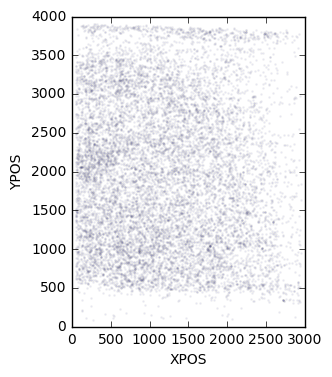

In [92]:
data0b = x_b[x_b.CAM_ID == 0].sample(12000)
data0b.plot.scatter(x='XPOS', y="YPOS",s=1, xlim=(0,3000),ylim=(0,4000), alpha=0.05)
plt.axes().set_aspect('equal')

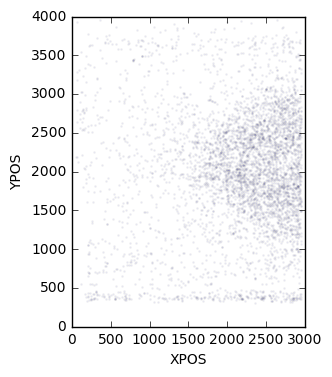

In [94]:
data2b = x_b[x_b.CAM_ID == 2].sample(4737)
data2b.plot.scatter(x='XPOS', y="YPOS",s=1, xlim=(0,3000),ylim=(0,4000), alpha=0.05)
plt.axes().set_aspect('equal')

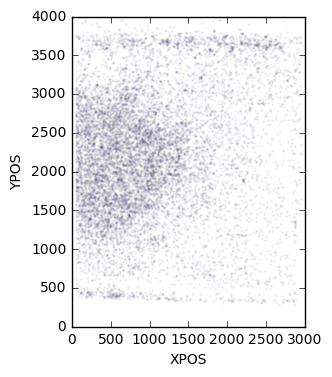

In [96]:
data1b = x_b[x_b.CAM_ID == 1].sample(12127)
data1b.plot.scatter(x='XPOS', y="YPOS",s=1, xlim=(0,3000),ylim=(0,4000), alpha=0.05)
plt.axes().set_aspect('equal')

# Plotten der Communities - Stündliche Netzwerke

In [7]:
g1 = nx.read_graphml("networks-hours/2015-08-21T01:00:00Z_1h_allCams_0.99conf_160dist_6ilen.graphml")

In [8]:
print(nx.info(g1))

Name: 
Type: Graph
Number of nodes: 767
Number of edges: 6446
Average degree:  16.8083


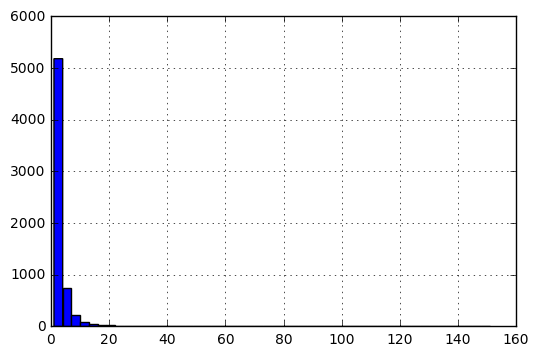

In [9]:
l = []

for e in g1.edges():
    l.append(G.get_edge_data(e[0],e[1]).get("weight"))

edge_weights = Series(l)
edge_weights.hist(bins=50)

In [10]:
for e in g1.edges():
    if (g1.get_edge_data(e[0],e[1]).get("weight") < 2):
        g1.remove_edge(e[0],e[1])

In [11]:
Gcc = sorted(nx.connected_component_subgraphs(g1), key = len, reverse=True)
print("Number of components: {}".format(len(Gcc)))

size_components = []
for comp in Gcc:
    size_components.append(nx.number_of_nodes(comp))
    
Counter(list(size_components))

Number of components: 111


Counter({1: 107, 2: 3, 654: 1})

In [12]:
G0 = Gcc[0]

In [13]:
c = list(nx.community.k_clique_communities(G0,3))

884, 3182, 3778, 3152, 3045, 2903, 660, 2924, 2546, 2866, 3290, 808, 3439, 3589, 3063, 3340, 2714, 2145, 3498, 3898, 2349, 2850, 2577, 3797, 3618, 2579, 3482, 3066, 3017, 2296, 3542, 3327, 2574, 3373, 2374, 424, 4049, 2476, 3947, 2265, 3961, 3125, 3741, 3817, 3390, 2557, 3703, 360, 4037, 2753, 3143, 2286, 2069, 948, 3256, 3538, 3206, 300, 2833, 72, 2747, 840, 332, 2420, 1028, 3593, 456, 3331, 40, 3091, 700, 2583, 2807, 3571, 2843, 3685, 2954, 3690, 2251, 2153, 3086, 3463, 3149, 3236, 3391, 380, 3473, 464, 3717, 2177, 3667, 2853, 2601, 2397, 2525, 4034, 3491, 4039, 3523, 2399, 3227, 952, 688, 2794, 2183, 404, 2053, 4093, 2102, 2345, 4054, 3907, 2919, 2668, 2462, 2048, 3578, 2865, 3897, 2523, 3394, 3008, 2725, 288, 2957, 4009, 408, 3646, 3707, 2287, 4013, 2821, 616, 2806, 3427, 1000, 116, 3705, 3621, 160, 4028, 3587, 2645, 3647, 2094, 876, 2086, 3379, 2569, 3437, 232, 996, 3059, 3762, 4022, 3731, 2430, 2235, 3447, 3316, 2900, 4017, 3321, 4067, 2882, 96, 3988, 3630, 240, 3279, 4094, 3235,

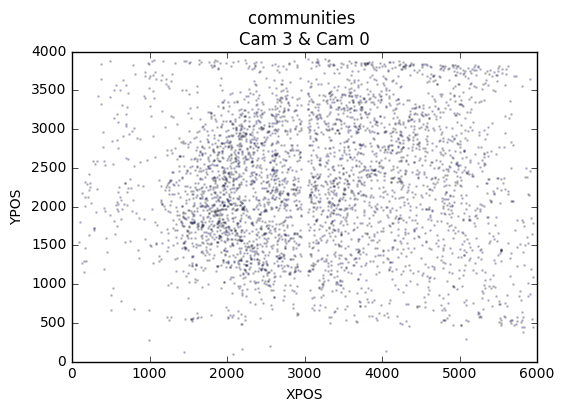

In [34]:
# for e,item in enumerate(c[:1]):

com = c[1]

comL = []
for i in com:
    comL.append(int(i))

ids = ', '.join([str(x) for x in comL])

print(ids)

sql = '''
    SELECT d.XPOS, d.YPOS, d.ID, fc.CAM_ID
    FROM DETECTIONS d
    INNER JOIN FRAME f
    ON d.FRAME_ID=f.FRAME_ID
    INNER JOIN FRAME_CONTAINER fc
    ON f.FC_ID=fc.FC_ID
    WHERE d.ID IN ({});
'''.format(ids)

x = pd.read_sql(sql, conn)

plotCommunitiesXY("communities", x, 3,0)

In [32]:
def plotCommunitiesXY(txt, df, camIDleft, camIDright, s=2000):
    data_l = df[df.CAM_ID == camIDleft].sample(s)
    data_r = df[df.CAM_ID == camIDright].sample(s)
    data_r.XPOS = data_r.XPOS + 3000
    data = pd.concat([data_l,data_r])
    data.plot.scatter(x='XPOS', y="YPOS",s=1, xlim=(0,6000),ylim=(0,4000), alpha=0.2)
    plt.axes().set_aspect('equal')
    plt.axes().set_title("{} \nCam {} & Cam {}".format(txt, str(camIDleft), str(camIDright)))

356, 2714, 2682


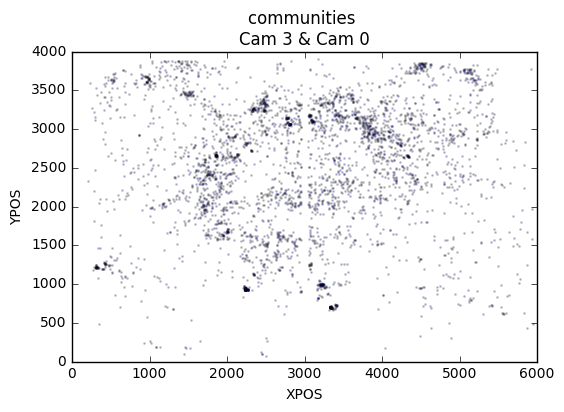

In [35]:
com = c[0]

comL = []
for i in com:
    comL.append(int(i))

ids = ', '.join([str(x) for x in comL])

print(ids)

sql = '''
    SELECT d.XPOS, d.YPOS, d.ID, fc.CAM_ID
    FROM DETECTIONS d
    INNER JOIN FRAME f
    ON d.FRAME_ID=f.FRAME_ID
    INNER JOIN FRAME_CONTAINER fc
    ON f.FC_ID=fc.FC_ID
    WHERE d.ID IN ({});
'''.format(ids)

x = pd.read_sql(sql, conn)

plotCommunitiesXY("communities", x, 3,0)

3461, 4037, 2953, 2365, 3966, 3774, 2066, 2488, 2869, 2625, 2527, 2817, 2090, 2467, 3444, 2076, 3897, 3004, 3936, 2349, 2968, 2660, 3972, 3618, 3574, 3702, 2821, 3259, 2911, 2574, 3216, 3754, 3953, 3373, 2407, 2946, 2738, 3539, 2645, 2387, 3185, 3432, 3799, 3555, 2234, 3405, 3364


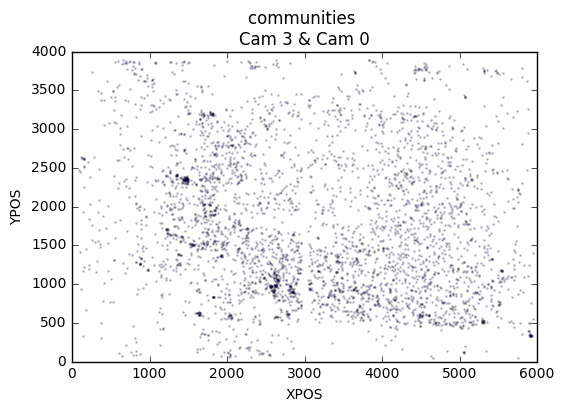

In [36]:
com = c[2]

comL = []
for i in com:
    comL.append(int(i))

ids = ', '.join([str(x) for x in comL])

print(ids)

sql = '''
    SELECT d.XPOS, d.YPOS, d.ID, fc.CAM_ID
    FROM DETECTIONS d
    INNER JOIN FRAME f
    ON d.FRAME_ID=f.FRAME_ID
    INNER JOIN FRAME_CONTAINER fc
    ON f.FC_ID=fc.FC_ID
    WHERE d.ID IN ({});
'''.format(ids)

x = pd.read_sql(sql, conn)

plotCommunitiesXY("communities", x, 3,0)

3715, 2653, 3351


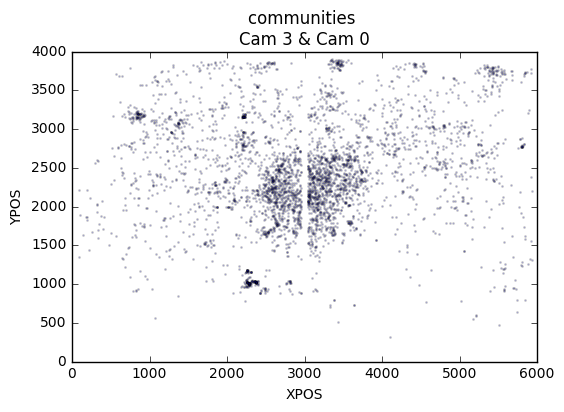

In [37]:
com = c[3]

comL = []
for i in com:
    comL.append(int(i))

ids = ', '.join([str(x) for x in comL])

print(ids)

sql = '''
    SELECT d.XPOS, d.YPOS, d.ID, fc.CAM_ID
    FROM DETECTIONS d
    INNER JOIN FRAME f
    ON d.FRAME_ID=f.FRAME_ID
    INNER JOIN FRAME_CONTAINER fc
    ON f.FC_ID=fc.FC_ID
    WHERE d.ID IN ({});
'''.format(ids)

x = pd.read_sql(sql, conn)

plotCommunitiesXY("communities", x, 3,0)

660, 4037, 3323, 3689


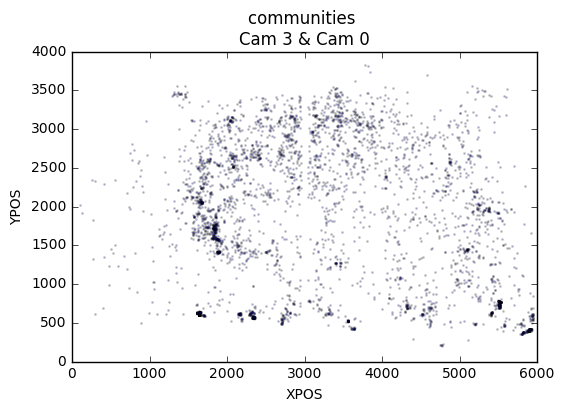

In [38]:
com = c[4]

comL = []
for i in com:
    comL.append(int(i))

ids = ', '.join([str(x) for x in comL])

print(ids)

sql = '''
    SELECT d.XPOS, d.YPOS, d.ID, fc.CAM_ID
    FROM DETECTIONS d
    INNER JOIN FRAME f
    ON d.FRAME_ID=f.FRAME_ID
    INNER JOIN FRAME_CONTAINER fc
    ON f.FC_ID=fc.FC_ID
    WHERE d.ID IN ({});
'''.format(ids)

x = pd.read_sql(sql, conn)

plotCommunitiesXY("communities", x, 3,0)

3331, 980, 2577, 2571, 2386, 4022, 3731, 3423, 2806, 3191, 3019, 2478, 900, 3835, 3362, 3715, 12, 3299, 2887, 2107, 3530, 3390, 2088, 2770, 3162, 3791, 3379, 2451, 3642, 3343, 3179, 308


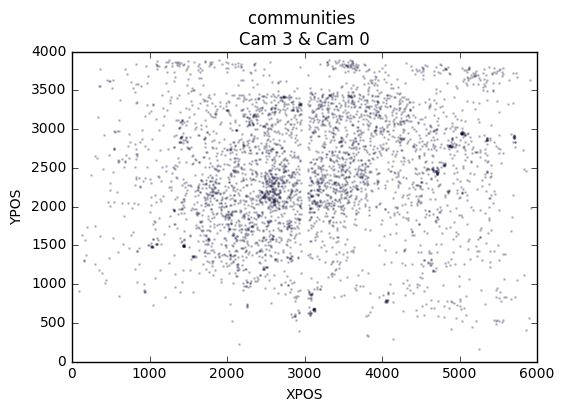

In [39]:
com = c[5]

comL = []
for i in com:
    comL.append(int(i))

ids = ', '.join([str(x) for x in comL])

print(ids)

sql = '''
    SELECT d.XPOS, d.YPOS, d.ID, fc.CAM_ID
    FROM DETECTIONS d
    INNER JOIN FRAME f
    ON d.FRAME_ID=f.FRAME_ID
    INNER JOIN FRAME_CONTAINER fc
    ON f.FC_ID=fc.FC_ID
    WHERE d.ID IN ({});
'''.format(ids)

x = pd.read_sql(sql, conn)

plotCommunitiesXY("communities", x, 3,0)

2794, 3066, 2821


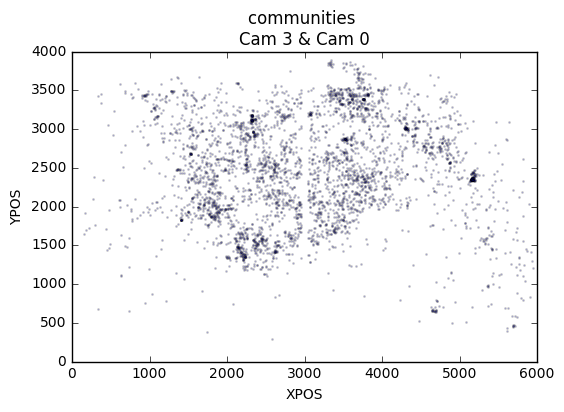

In [40]:
com = c[6]

comL = []
for i in com:
    comL.append(int(i))

ids = ', '.join([str(x) for x in comL])

print(ids)

sql = '''
    SELECT d.XPOS, d.YPOS, d.ID, fc.CAM_ID
    FROM DETECTIONS d
    INNER JOIN FRAME f
    ON d.FRAME_ID=f.FRAME_ID
    INNER JOIN FRAME_CONTAINER fc
    ON f.FC_ID=fc.FC_ID
    WHERE d.ID IN ({});
'''.format(ids)

x = pd.read_sql(sql, conn)

plotCommunitiesXY("communities", x, 3,0)